<a href="https://colab.research.google.com/github/CharlesCarpes/suporte_multi_modal/blob/main/MultiModalAlura.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Projeto Final Imersão Inteligência Artificial 2ª Edição - Alura


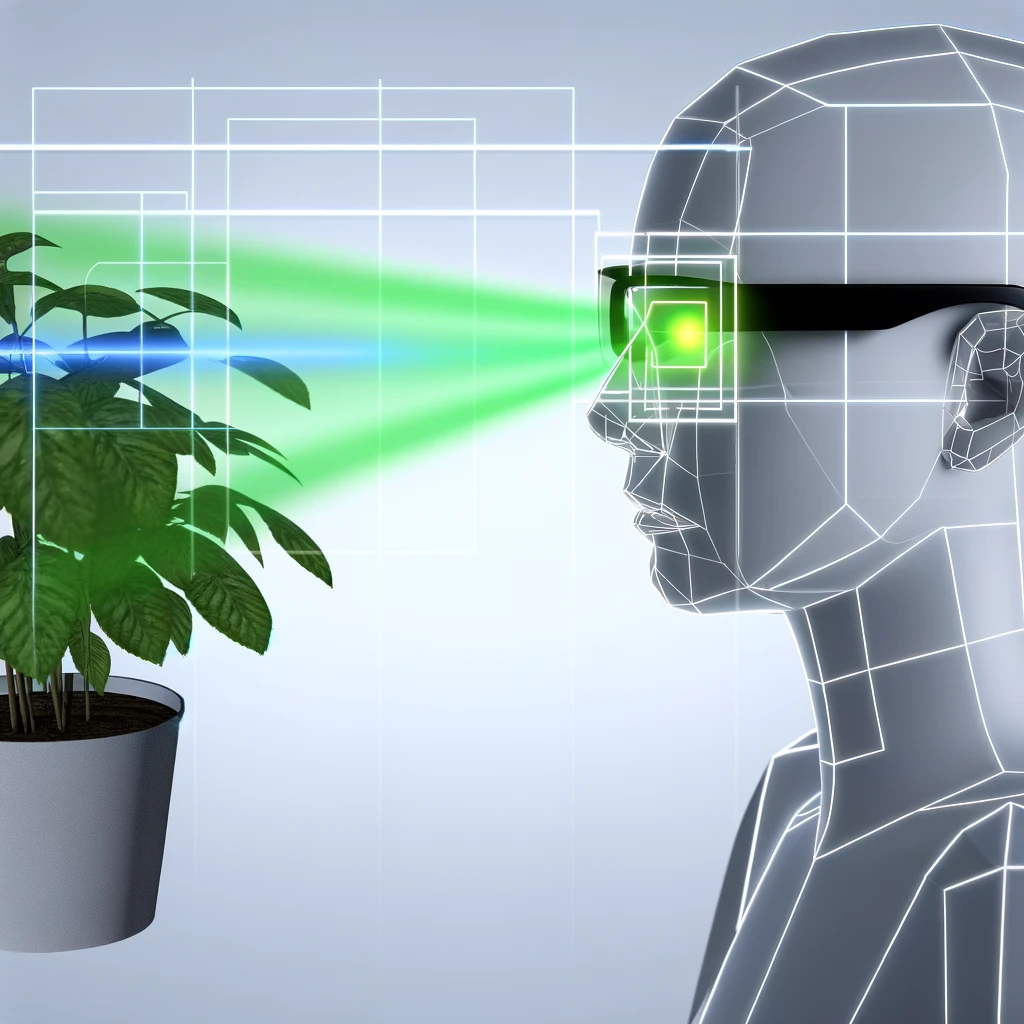

**Fonte**: gerada por "Dall - E" em "10 de maio de 2024".

Este projeto utiliza a API do Gemini para permitir que pessoas com deficiência visual possam obter a descrição de imagens através de comandos de voz.

O código foi escrito em Python e usa o Google COLAB para interagir com os modelos generativos do Google. Assim, é possível utilizar esta solução diretamente em qualquer dispositivo (PC, Notebook ou celular Android) que tenha o navegador Chrome instalado.

O caso de uso principal para qual o projeto foi pensado é o de facilitar o acesso à informações visuais por pessoas com algum tipo de deficiência visual. Em uma futura versão, o código poderia ser embarcado em um equipamento vestível (como óculos ou um capacete com câmera) e o usuário poderia fazer consultas por voz através da API para obter a descrição das imagens capturadas pela câmera do dispositivo. Neste caso de uso, o deficiente visual poderia transitar pela cidade com o equipamento e ser capaz de localizar informações visuais como placas de trânsito, pontos de ônibus, estabelecimentos comerciais e, eventualmente, reconhecer novos obstáculos no trajeto.

Na versão atual essa funcionalidade já pode ser utilizada através de um celular android com Chrome instalado. Porém, o usuário precisa ser capaz de abrir o arquivo no Chrome e clicar no botão de captura de imagem.

### Outros casos de uso incluem:

1. **Assistente virtual acionado por voz (semelhante à Alexa)** com capacidade de visão computacional que poderia ser utilizada em dispositivos vestíveis ou móveis (como celulares, drones e veículos robóticos). No caso de dispositivos vestíveis, a assistente poderia ser acionada por um botão físico e, a partir do toque no botão, iniciar a conversa e a captura de imagens.
2. **Análise de emoções com a webcam do usuário**: Com uma pequena modificação no código, é possível utilizar as imagens da webcam do usuário para identificar suas emoções durante um diálogo de atendimento com um chatbot. Isso seria especialmente interessante para chatbots utilizados para atendimento a demandas de clientes (identificar ansiedade, humor do cliente em casos de reclamação) e em sistemas de vendas automatizadas onde o cliente poderia receber informações sobre produtos e dialogar com o chatbot para efetivar a compra. Com acesso à câmera, o chatbot poderia avaliar o nível de interesse dos clientes em relação a cada produto apresentado através da análise de suas expressões faciais e linguagem corporal.
3. **Sistema de segurança para identificação de pessoas suspeitas**: O mesmo sistema poderia ser utilizado em sistemas de segurança para identificar pessoas suspeitas em um local monitorado e iniciar um aviso ao usuário.

**Autor**: Charles Quevedo Carpes
**Contado**: charles.carpes@gmail.com

O autor deste projeto está atribuindo a ele a licença "**CC BY 4.0 DEED - Attribution 4.0 International**". Esta licença permite que qualquer pessoa distribua, edite, adapte e crie a partir do seu trabalho, mesmo para fins comerciais, desde que lhe atribuam o devido crédito pela criação original.

**Passo 1 - Intalações e importações**: Para facilitar a utilização real deste projeto vou inserir todos os comandos de instalação e importação na mesma célula com objetivo de reduzir a quantidade de cliques necessários para rodar o projeto. Você pode executar todas as células em sequência usando o comando CRTL+F9, se estiver usando um computador.

Esta escolha tornará o código menos didático. Vou tentar contornar isso usando comentários no próprio código.

In [ ]:
# Instalando biblioteca OpenCV que permite tratamento de imagens
!pip install opencv-python
# Instalando biblioteca gTTS (Google Text-to-Speech) que permite converter texto em fala.
!pip install gTTS
# Instalando biblioteca necessária para converter áudio em texto
!pip install git+https://github.com/openai/whisper.git -U -q

# Importanto os pacotes que serão utilizados ao longo do projeto
from IPython.display import display, Javascript, Image, Audio
from google.colab import output
from google.colab.output import eval_js
from base64 import b64decode
import cv2
import numpy as np
import PIL.Image
from gtts import gTTS
import google.generativeai as genai
from google.colab import userdata
import time
import whisper
import warnings
warnings.filterwarnings("ignore")



**Passo 2 - Definindo as funções que serão usadas:** Novamente vou definir todas as funções na mesma célula para facilitar a utilização deste notebook.

A descrição da função será feita usando "docstrings".

In [ ]:
def LerTexto(text):
  """
    Converte um texto dado em áudio e reproduz o áudio automaticamente.

    Utiliza a biblioteca gTTS para gerar um arquivo de áudio a partir de um texto,
    configurando o idioma para português brasileiro. O arquivo de áudio gerado é salvo localmente
    e reproduzido automaticamente.

    Parametros:
    text (str): O texto que será convertido em áudio.

    Returns:
    None: A função não retorna nada, mas salva e reproduz um arquivo de áudio.

    Exemplo:
    >>> LerTexto("Olá, mundo!")
    # Isso irá gerar e reproduzir o áudio "Olá, mundo!" em português brasileiro.
"""
  #Ajustes para o português brasileiro
  tts = gTTS(text, lang ="pt" ,tld="com.br")
  #Definindo o nome do arquivo que será salvo
  gtts_audio_file = f'TextoEmAudio-gtts.wav'
  #Salvando o arquivo de áudio
  tts.save(gtts_audio_file)
  #Reproduzindo o áudio automaticamente
  display(Audio(gtts_audio_file, autoplay=True))


# --------------------------------------------------------------------------------

def record_audio(duration=5):

  """
    Grava áudio do microfone do usuário por um período especificado e salva o arquivo localmente.

    Achei melhor fixar o tempo de 5 segundos para capturar o áudio do usuário para não
    ter um arquivo muito grande e para evitar que ele clique para gravar e depois clique
    novamente para parar a gravação (lembre que o objetivo do projeto era ser útil para
    pessoas com deficiência visual, então quanto menos cliques melhor).

    Esta função inicia com um bip para avisar que está iniciando a gravação, grava o
    áudio utilizando o microfone padrão do dispositivo e termina com outro bip
    indicando o final da gravação. O áudio é capturado em formato WAV.
    A função também converte o áudio gravado em um objeto Blob, transforma em Base64, e finalmente
    salva como um arquivo WAV no sistema de arquivos local.

    Parametros:
    duration (int, optional): Duração da gravação em segundos. O valor padrão é 5 segundos.

    Returns:
    bytes: Retorna os dados binários do arquivo de áudio gravado.

    Exemplo:
    >>> audio_data = record_audio(10)
    # Isso grava o áudio por 10 segundos e retorna os dados binários do arquivo.
"""
  js = Javascript('''
    async function recordAudio(duration) {
        const audioContext = new AudioContext();

        // Função para gerar um bip
        function beep(duration = 200, frequency = 520, volume = 1) {
            const oscillator = audioContext.createOscillator();
            const gain = audioContext.createGain();
            oscillator.connect(gain);
            oscillator.frequency.value = frequency;
            oscillator.type = "sine";
            gain.connect(audioContext.destination);
            gain.gain.value = volume;
            oscillator.start(audioContext.currentTime);
            oscillator.stop(audioContext.currentTime + duration / 1000);
        }

        // Acessar o microfone do usuário
        const stream = await navigator.mediaDevices.getUserMedia({audio: true});
        const mediaRecorder = new MediaRecorder(stream);
        const audioChunks = [];

        // Capturar chunks de áudio
        mediaRecorder.addEventListener("dataavailable", event => {
            audioChunks.push(event.data);
        });

        // Emitir um bip antes de começar a gravação
        beep();

        // Começar a gravação
        mediaRecorder.start();

        // Aguardar o tempo especificado antes de parar a gravação
        await new Promise(resolve => setTimeout(() => {
            // Emitir um bip ao final da gravação
            beep();
            mediaRecorder.stop();
            stream.getTracks().forEach(track => track.stop()); // Parar todas as tracks para liberar o microfone
            resolve();
        }, duration * 1000));

        // Esperar a gravação parar
        await new Promise(resolve => mediaRecorder.addEventListener("stop", resolve));

        // Converter os chunks de áudio para um único Blob
        const audioBlob = new Blob(audioChunks, {type: 'audio/wav'});

        // Converter o Blob para Base64
        const reader = new FileReader();
        reader.readAsDataURL(audioBlob);
        await new Promise(resolve => reader.onloadend = resolve);

        return reader.result;
    }
    ''')
  display(js)
  data = output.eval_js('recordAudio({})'.format(duration))
  binary = b64decode(data.split(',')[1])
  with open('/content/audio.wav', 'wb') as f:
    f.write(binary)  # Salvar o arquivo de áudio
  return binary


# -----------------------------------------------------------------------------------
def take_photo(filename='photo.jpg', quality=0.8):
  """
    Captura uma foto usando a webcam do usuário e salva no sistema de arquivos.
    Funciona também em celulares android, mas não testei em sistemas IOS.

    Esta função cria uma interface de usuário temporária no navegador com um vídeo
    e um botão de captura. Quando o usuário clica no botão "Capture", a foto é
    tirada do vídeo ao vivo da webcam, convertida para JPEG com a qualidade
    especificada, e então salva localmente com o nome de arquivo fornecido.

    Também pensei em usar um "timer" para captura da foto, mas achei melhor usar
    um botão para capturar a foto. Este projeto foi feito em 24h, então o botão
    ajudou a agilizar os testes. No futuro pode ser melhorado com um "timer" ou
    um comando de voz para capturar a foto.

    Parametros:
    filename (str, optional): O nome do arquivo para salvar a imagem capturada. O padrão é 'photo.jpg'.
    quality (float, optional): A qualidade da imagem JPEG a ser salva. Valores entre 0 e 1, onde 1 é a máxima qualidade.
                               O valor padrão é 0.8.

    Returns:
    str: O nome do arquivo onde a foto foi salva.

    Exemplo:
    >>> saved_filename = take_photo('minha_foto.jpg', 0.9)
    # Isso capturará uma foto usando a webcam, com qualidade de 0.9, e salvará como 'minha_foto.jpg'.
    """
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();


      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Espera o clique para capturar a foto.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
  ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

def audioDoUsuario():
    """
    Converte o áudio do usuário em texto utilizando o modelo de transcrição Wisper.

    Esta função assume que existe um arquivo chamado 'audio.wav' que contém a gravação
    mais recente do áudio do usuário. O áudio é processado pelo modelo Wisper, que
    transcreve o conteúdo falado para texto. O arquivo 'audio.wav' é sobrescrito
    a cada nova gravação, garantindo que apenas o áudio mais recente seja mantido.

    Returns:
    str: O texto transcrito do áudio mais recente do usuário.

    Exemplo:
    >>> texto_transcrito = audioDoUsuario()
    # Isso retorna o texto transcrito do arquivo 'audio.wav' que já deve estar na memória!
    """
    #Configurações do Wisper
    model_options = ['tiny','small', 'medium', 'large']
    model_option = model_options[2]
    model = whisper.load_model(model_option)
    #Fim das configurações do Wisper
    result = model.transcribe('audio.wav', language="pt")
    return result['text']


def continua_conversa():
  LerTexto("Vamos continuar? Espere o bip e diga alguma coisa. Caso queira parar diga: 'Deu pra ti' ")
  # Pausa o código por 5 segundos
  time.sleep(10)
  gravacao = record_audio(duration=5)
  # Pausa o código por 10 segundos
  time.sleep(10)
  LerTexto("Espere um pouco. Estou interpretando o que você disse. Isso pode demorar")
  mensagem = audioDoUsuario()
  prompt_de_controle = f'''Você está recebendo a mensagem de um usuário e sua resposta
  será convertida em áudio para ele, então seja direto e simples para o áudio não
  ficar muito longo. Vou usar o texto da sua resposta como controle, então quero
  que seja preciso em me retornar a palavra "123KX" se a mensagem contiver a expressão
  "Deu pra ti". Quero que me retorne a palavra "456BWG" se a mensagem pedir para descrever
  uma imagem ou algo do tipo. Caso a mensagem tenha uma pergunta, retorne sua resposta
  de forma clara, curta e direta utilizando no máximo 20 palavras. A mensagem é:
  "{mensagem}".'''
  return prompt_de_controle

def inicia_conversa():
  LerTexto("Vamos começar? Espere o bip e diga alguma coisa.")
  # Pausa o código por 5 segundos
  time.sleep(5)
  gravacao = record_audio(duration=5)
  # Pausa o código por 10 segundos
  time.sleep(10)
  LerTexto("Espere um pouco. Estou interpretando o que você disse. Isso pode demorar")
  mensagem = audioDoUsuario()
  prompt_de_controle = f'''Você está recebendo a mensagem de um usuário e sua resposta
  será convertida em áudio para ele, então seja direto e simples para o áudio não
  ficar muito longo. Vou usar o texto da sua resposta como controle, então quero
  que seja preciso em me retornar a palavra "123KX" se a mensagem contiver a expressão
  "Deu pra ti". Quero que me retorne a palavra "456BWG" se a mensagem pedir para descrever
  uma imagem ou algo do tipo. Caso a mensagem tenha uma pergunta, retorne sua resposta
  de forma clara, curta e direta utilizando no máximo 20 palavras. A mensagem é:
  "{mensagem}".'''
  return prompt_de_controle


**Passo 3 - Escolhendo o modelo que será usado:** Testei os modelos 'gemini-pro-vision' e 'gemini-1.5-pro-latest'. Ambos tiveram bons resultados. Vou usar o 'gemini-pro-vision' pois como é mais antigo acredito que será mais barato, mas não consultei os custos de cada modelo.


In [ ]:
# Para funcionar você precisa ter a sua chave api do Gemini!
chave = userdata.get('secretName')
genai.configure(api_key=chave)
modelo = genai.GenerativeModel('gemini-1.5-pro-latest')

**Passo 4 - Juntando tudo e colocando para rodar!**

In [ ]:
texto_inicial = '''Olá! Serei seu assistente virtual. Para funcionar corretamente
você precisará autorizar que o navegador acesse sua câmera e microfone.
Mas isso apenas na primeira vez. Depois basta interagir comigo por voz.
Ainda estou em fase de testes, então posso demorar um pouco para responder.
Você vai ouvir um bip quando iniciar a gravação do seu áudio e outro quando terminar.
Estou programado para gravar 5 segundos, então seja rápido.
Quando quiser terminar a conversa, basta dizer DEU PRA TI!

Se quiser que eu descreva uma imagem que eu consiga ver através da sua
webcam basta pedir que eu descreverei a imagem.

Ou podemos apenas conversar.'''

#LerTexto(texto_inicial)
prompt_de_controle =inicia_conversa()

while True:
  response = modelo.generate_content(prompt_de_controle)
  response.resolve()
  if ("123KX \n" in response.text or "123kx" in response.text):
    break
  elif ("456BWG \n" in response.text or "456bwg" in response.text):
    LerTexto("Agora vamos testar minha capacidade de descrever imagens. Estou acessando sua webcam.")
    # Pausa o código por 8 segundos
    time.sleep(8)
    LerTexto("Ao clicar no botão capturar, vou coletar a imagem e descrever para você. ")
    nome_foto = take_photo()
    img = PIL.Image.open('photo.jpg')
    modelo = genai.GenerativeModel('gemini-1.5-pro-latest')
    response = modelo.generate_content(["Faça uma breve descrição da imagem em até 20 palavras. Envie sua resposta em português.", img], stream=True)
    response.resolve()
    print(response.text)
    LerTexto(response.text)
    time.sleep(12)
  else:
    print(response.text)#Apagar. Apenas para controle
    LerTexto(response.text)
    time.sleep(10)
  prompt_de_controle = continua_conversa()


time.sleep(5)
LerTexto("Obrigado pela conversa. Até mais!")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Uma mão segura um caderno com anotações escritas à mão. 



<IPython.core.display.Javascript object>

Fundador da Ferrari e piloto de carros de corrida italiano. 



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Uma mão segura um folheto preto com a imagem de um mouse gamer azul. 



<IPython.core.display.Javascript object>

A Porsche foi criada em 1931. 



<IPython.core.display.Javascript object>